In [93]:
# Import libraries.
import re
import numpy as np
import tensorflow as tf
from tensorflow.contrib import learn
import os
import time
import datetime
from datetime import timedelta
from IPython.display import clear_output
import pickle
import wordcloud
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools
%matplotlib inline

In [2]:
#function to clean the data
def clean_string(string):
    string = string.lower()
    # remove web addresses
    string = re.sub(r"(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", 
                    " ", string)
    string = re.sub(r"[^a-z0-9!\?\']", " ", string)
    string = re.sub(r"'s", " 's", string)
    string = re.sub(r"s' ", " 's", string)
    string = re.sub(r"'ve", " 've", string)
    string = re.sub(r"n't", " n't", string)
    string = re.sub(r"'re", " 're", string)
    string = re.sub(r"'d", " 'd", string)
    string = re.sub(r"'ll", " 'll", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip()

In [3]:
#sets values for the default graph
dropout_keep_prob = 1.0

# create batching object
with open('/share/yelp/params_voc_seq_num.pickle', 'rb') as fp:
    vocab, seq_len, num_lines = pickle.load(fp)

In [4]:
class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    
    Baseline model based off of example from WildML (link below)
    http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
    """
    def __init__(
      self, sequence_length, num_classes, vocab_size,
      embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            W = tf.Variable(
                tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                name="W")
            self.embedded_chars = tf.nn.embedding_lookup(W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(3, pooled_outputs)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            W = tf.get_variable(
                "W",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # CalculateMean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(self.scores, self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [6]:
with tf.Graph().as_default():
    sess = tf.Session()
    with sess.as_default():
        cnn = TextCNN(
            sequence_length=seq_len,
            num_classes=5,
            vocab_size=len(vocab),
            embedding_size=32,
            filter_sizes=[3,4,5],
            num_filters=128)
        
        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(1e-3)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)
        
        saver = tf.train.Saver(tf.all_variables())
        saver.restore(sess, '/home/james/yelp_cnn/runs/1481598633/checkpoints/model-40000')
        
        def softmax(x):
            """
            Compute softmax values for each sets of scores in x.  
            """
            return np.exp(x) / np.sum(np.exp(x), axis=-1)
        
        def predict_stars(input_str, verbose=True):
            rev = clean_string(input_str).split(' ')
            rev_arr = np.zeros((1,seq_len), dtype=int)
            for i,w in enumerate(rev):
                if not vocab.get(w):
                    rev_arr[0,i] = vocab['_RARE_']
                else:
                    rev_arr[0,i] = vocab[w]
            
            feed_dict = {cnn.input_x: rev_arr, cnn.dropout_keep_prob: 1.0}
            scores = softmax(sess.run([cnn.scores], feed_dict)).squeeze()
            if verbose:
                print('Score probabilities: {:.3f} {:.3f}, {:.3f}, {:.3f}, {:.3f}\nFor input review:\n{}'
                      .format(*scores, ' '.join(rev)))
            return scores

In [ ]:
# gather scores for each word in the vocabulary
word_scores = {}
for i,w in enumerate(vocab):
    word_scores[w] = list(predict_stars(w,False))
    if i%1000 == 0:
        print(i, end=' ')

In [33]:
# create a dictionary of 1 to 5 star documents
star_docs = defaultdict(list)
for w,sc in word_scores.items():
    for i in range(5):
        star_docs[i+1] += [(w, int(100*sc[i]))]

In [77]:
# create a word cloud for each star rating
for i in range(1,6):
    WC = wordcloud.WordCloud(width=800, height=400)
    WC.generate_from_frequencies(star_docs[i])
    WC.to_file('{}star.png'.format(i))

In [95]:
# create a confustion matrix from the first 50k reviews
# inplace of dedicated test set, due to processing changes
cm = np.zeros((5,5),int)
with open('/share/yelp/yelp_academic_dataset_review_clean_vocab_only.csv', 'r') as fp:
    header = next(fp)
    for i in range(50000):
        rv, st = next(fp).strip().split(',')
        cm[int(st)-1, predict_stars(rv, False).argmax()] += 1
        if i>0 and i%10000==0:
            print(i, end=' ')

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 

In [90]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

Confusion matrix, without normalization
[[ 5100   902   201    16   171]
 [ 1214  2163  1395   124   165]
 [  325   795  3940  1602  1057]
 [  128   120  1791  4941  7588]
 [  144    42   281  1126 14669]]


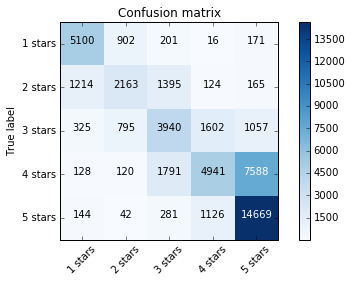

In [103]:
plot_confusion_matrix(cm, classes=['{} stars'.format(i+1) for i in range(5)])
plt.savefig('confusion_matrix.png')

In [104]:
correct_predict = (cm*np.eye(5,dtype=int)).sum()
incorrect_predict = (cm-cm*np.eye(5,dtype=int)).sum()
accuracy = correct_predict/cm.sum()